# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on April 6, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary: 
### 1. The logistic model was applied to 76 countries
### 2. Mean turning point for these countries is on 2020-03-28 (This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-04-29
### 4. The numbers of confirmed cases in France, US, Spain,	Germany, United Kingdom may exceed those in China by May, 2020
### 5. Comparing to last week, more countries can be modeled by logistic model, indicating that an increase in number of confirmed cases globally and more countries are at turning points
### 6. Looking at top 5 countries, France will grow fast while US, Spain, Germany will start to decrease in April
### 7. By looking at CruveTop and comparing from last week, situation in most countries will stablize in the begining of May
  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('time_series_covid19_confirmed_global.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,110,110,120,170,174,237,273,281,299,349
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,186,197,212,223,243,259,277,304,333,361
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,409,454,511,584,716,847,986,1171,1251,1320
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,267,308,334,370,376,390,428,439,466,501
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,5,7,7,7,8,8,8,10,14


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,569,573,577,577,580,580,582,584,585,586
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,578,578,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,331,337,338,340,343,345,345,349,350,350
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,136,136,138,138,138,138,138,138,138,138


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  0,  0]);
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt);
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt);
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases', fontsize=20);
    plt.title('Cumulative number of confirmed cases', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

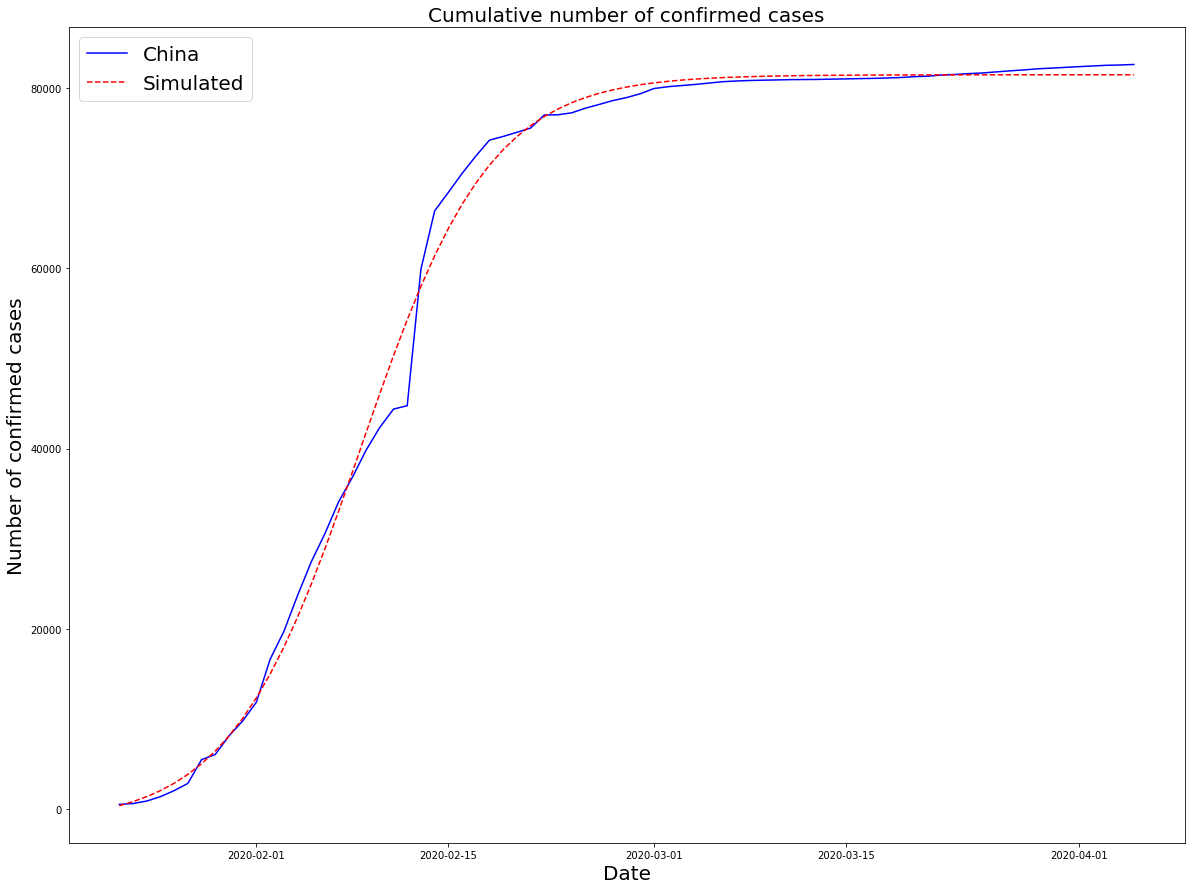

In [8]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [9]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.9958264103140392


In [11]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-08 18:17:49.946668800


In [12]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-12 10:07:16.139884800
The total number of confirmed cases is  81458.78251895956


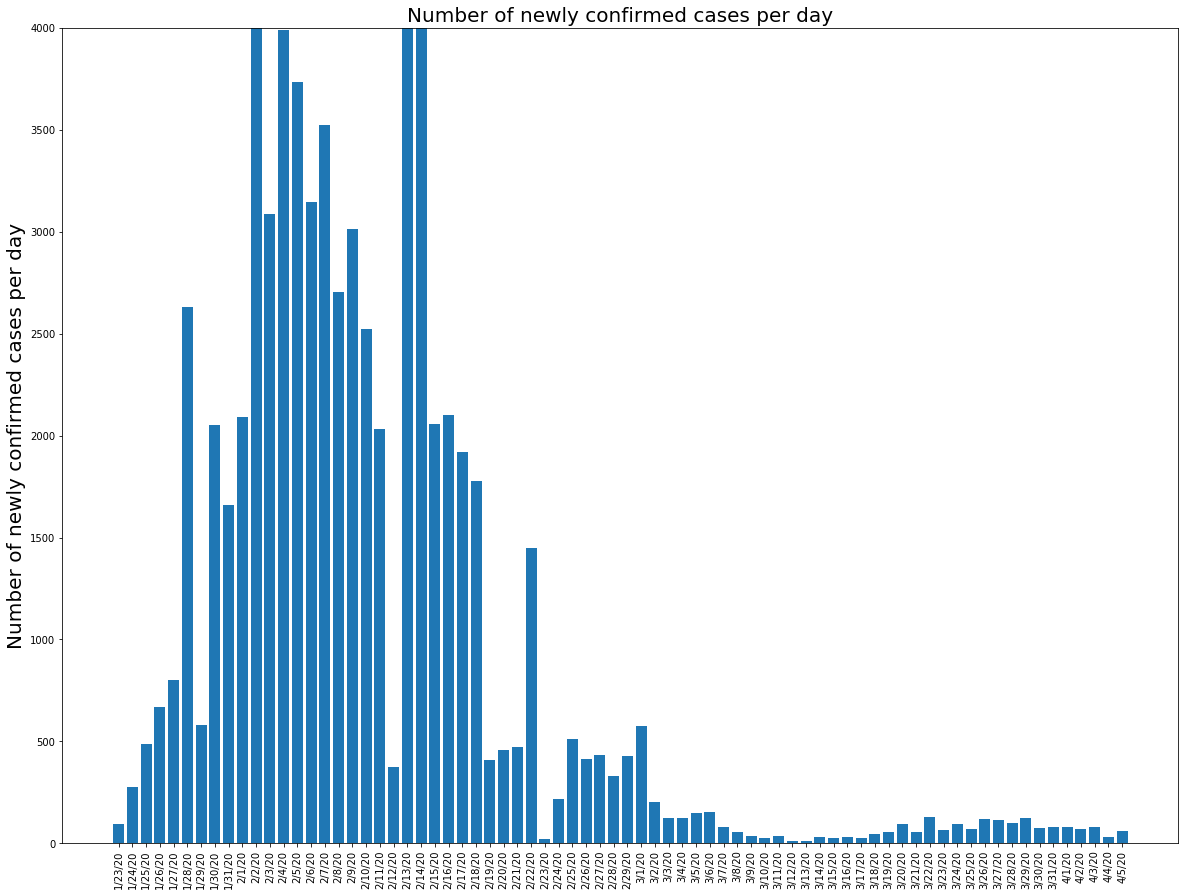

In [13]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [14]:
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  0,  0]);
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]]);
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy());
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt);
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Algeria
R^2 =  0.9972448458978167
The day reaches the turning point is on:  2020-04-05 21:19:09.921360
The day reaches the top of the curve is on:  2020-05-12 10:33:28.671811200
The total number of confirmed cases is  2988.980527953703
Andorra
R^2 =  0.997731517070717
The day reaches the turning point is on:  2020-03-26 20:28:56.267932800
The day reaches the top of the curve is on:  2020-04-21 01:30:52.081920
The total number of confirmed cases is  513.5867738247968
Argentina
R^2 =  0.9972240859896917
The day reaches the turning point is on:  2020-03-30 19:50:00.431577600
The day reaches the top of the curve is on:  2020-04-30 15:03:03.619180800
The total number of confirmed cases is  1920.2326725172552
Armenia
R^2 =  0.996614925282813
The day reaches the turning point is on:  2020-04-01 14:40:16.537900800
The day reaches the top of the curve is on:  2020-05-10 21:18:35.615808
The total number of confirmed cases is  1271.3522989979347
Australia
R^2 =  0.9996216310952274
The day reaches

C:\Users\erwin\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Bosnia and Herzegovina
R^2 =  0.9983253396837346
The day reaches the turning point is on:  2020-04-01 21:13:59.216851200
The day reaches the top of the curve is on:  2020-05-06 13:09:48.531945600
The total number of confirmed cases is  1024.9414485588384
Brazil
R^2 =  0.9969930145687191
The day reaches the turning point is on:  2020-04-06 13:25:19.016054399
The day reaches the top of the curve is on:  2020-05-13 12:23:32.682163200
The total number of confirmed cases is  26418.400100669394
Bulgaria
R^2 =  0.9969994361306097
The day reaches the turning point is on:  2020-03-27 07:31:01.547385600
The day reaches the top of the curve is on:  2020-05-02 10:36:56.966313600
The total number of confirmed cases is  611.8992563921877
Cameroon
R^2 =  0.987689556690122
The day reaches the turning point is on:  2020-04-16 15:19:55.347110400
The day reaches the top of the curve is on:  2020-05-15 11:08:26.924064
The total number of confirmed cases is  11644.749142239949
Canada
R^2 =  0.9981225947662

Morocco
R^2 =  0.9974343868347371
The day reaches the turning point is on:  2020-04-01 08:56:16.504627199
The day reaches the top of the curve is on:  2020-05-02 06:03:46.403510400
The total number of confirmed cases is  1415.3708212762017
Netherlands
R^2 =  0.9996522026179416
The day reaches the turning point is on:  2020-03-29 12:00:57.704486400
The day reaches the top of the curve is on:  2020-05-03 10:33:55.541174400
The total number of confirmed cases is  22458.843172079825
New Zealand
R^2 =  0.9976878518818526
The day reaches the turning point is on:  2020-03-30 02:15:53.324006400
The day reaches the top of the curve is on:  2020-04-22 15:44:41.771068800
The total number of confirmed cases is  1172.6650078830926
North Macedonia
R^2 =  0.9946400337077148
The day reaches the turning point is on:  2020-04-03 03:55:09.628982400
The day reaches the top of the curve is on:  2020-05-13 13:46:11.837568
The total number of confirmed cases is  904.8414975040714
Norway
R^2 =  0.997910287346

In [15]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  76


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
27,France,0.99328,2020-04-17 12:00:44.817148799,2020-06-08 09:47:33.749318400,584673
75,US,0.999344,2020-04-02 05:31:16.666118400,2020-05-01 21:36:15.703372800,509360
66,Spain,0.999663,2020-03-28 21:17:34.057622400,2020-04-30 07:36:24.481123199,159422
28,Germany,0.999187,2020-03-29 00:11:37.860230400,2020-05-02 14:40:16.377542400,123797
73,United Kingdom,0.999552,2020-04-04 19:31:57.684835200,2020-05-09 19:39:44.313436800,93859.7
14,China,0.995826,2020-02-08 18:17:49.944681600,2020-03-12 10:07:16.143513600,81458.8
32,India,0.994862,2020-04-19 15:39:40.044729600,2020-05-30 05:58:25.080182400,47379
71,Turkey,0.998668,2020-04-01 22:38:39.802963200,2020-04-24 18:41:43.301587200,36994
54,Peru,0.9948,2020-04-23 09:28:10.122067200,2020-06-10 18:00:57.487795200,32141.9
7,Belgium,0.998881,2020-03-31 07:39:09.121852800,2020-05-02 14:30:59.538096,26633.2


In [16]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-03-28 18:19:07.498898432
Mean CurveTop for these countries is  2020-04-29 08:52:33.576646656


## Examples

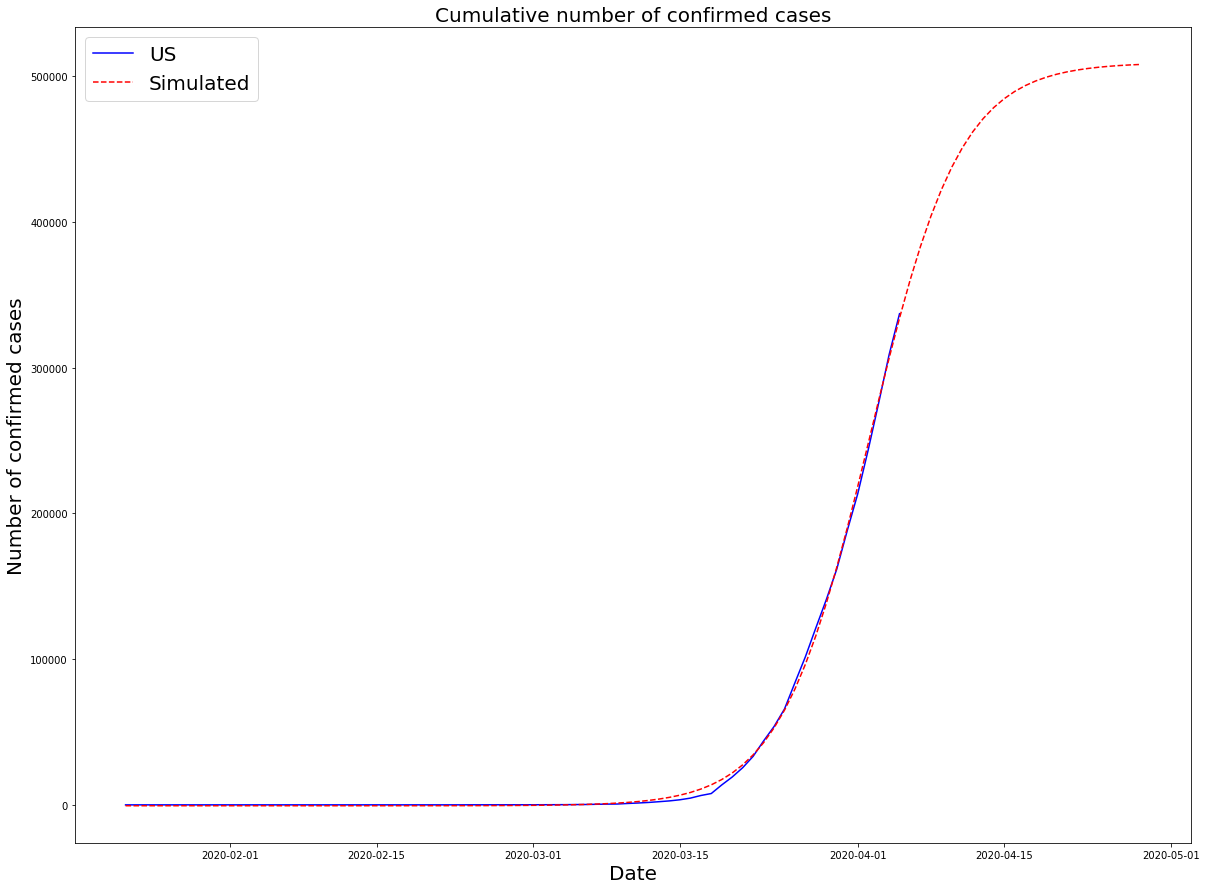

In [17]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

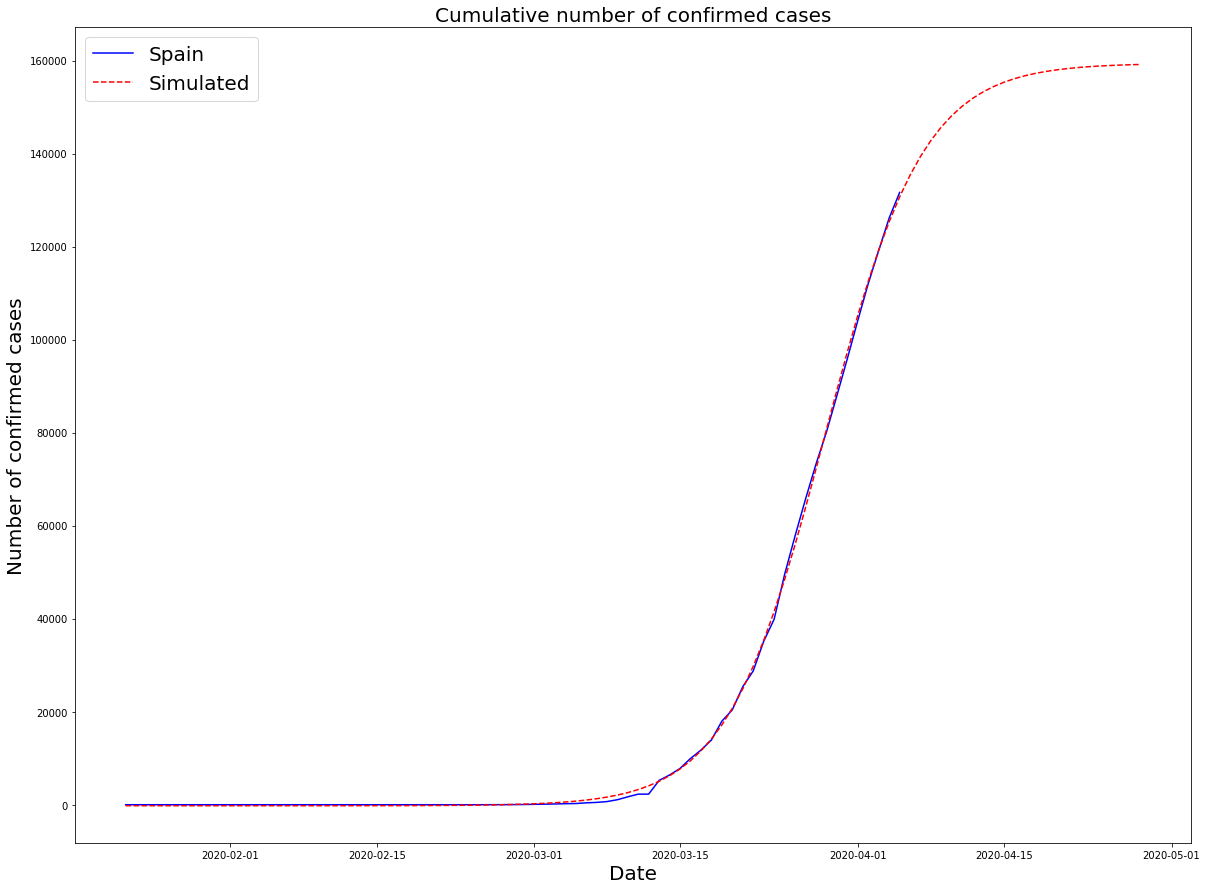

In [18]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

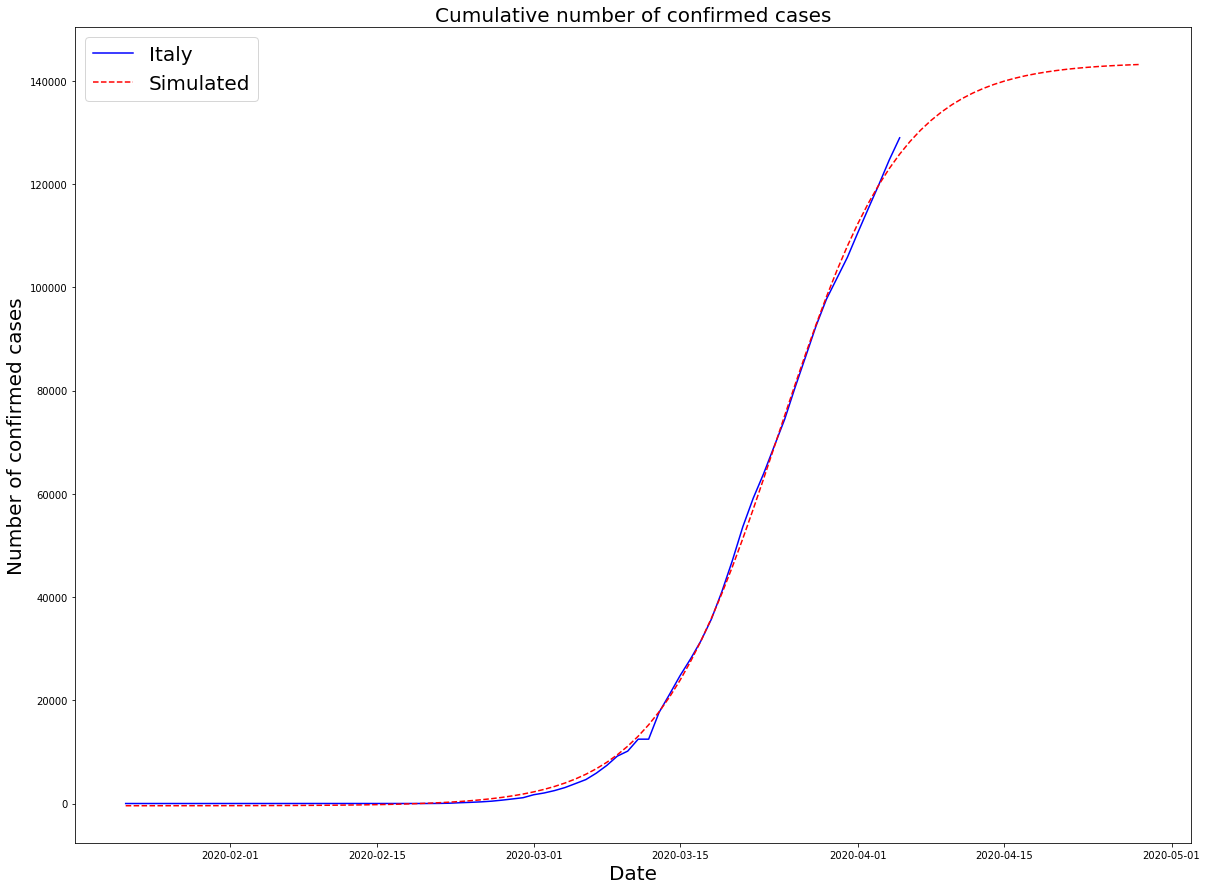

In [19]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

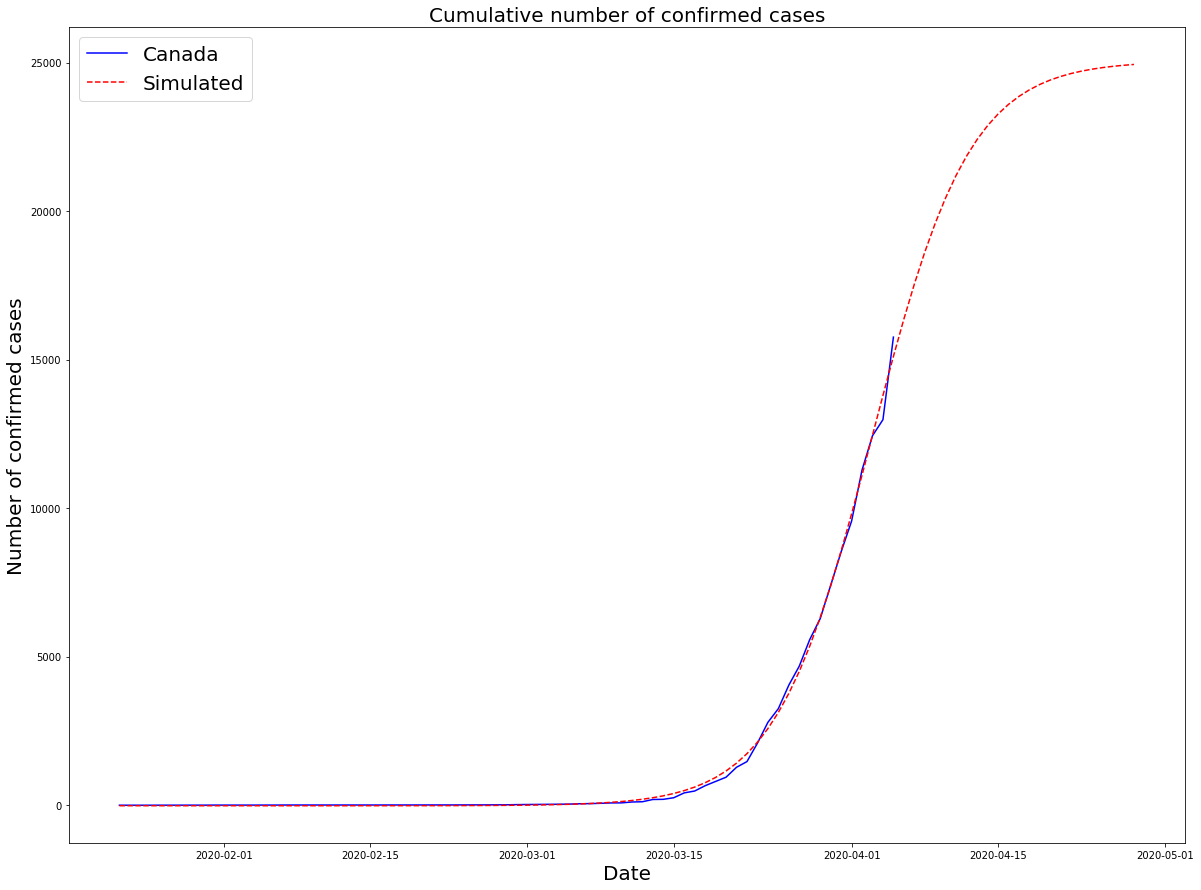

In [20]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);